In [ ]:
import re
import os
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from fa2 import ForceAtlas2
from tqdm import tqdm
from scipy.sparse import lil_matrix
from collections import Counter
from itertools import combinations
import community.community_louvain as community_louvain

In [ ]:
"""
TODO: 
- Move functions into utils.py script

"""

In [ ]:
def plot_degree_distribution(degrees, title, ax):
    ax.hist(degrees, bins=55, color='darkorange', edgecolor='black')
    ax.set_xlabel('# Reviewing same business')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

def plot_degree_distributions(partition, G, plot_entire_graph=False, figsize=(18, 12)):
    if plot_entire_graph:
        fig, ax = plt.subplots(figsize=(9, 6))
        degrees = [d for n, d in G.degree()]
        plot_degree_distribution(degrees, 'Degree Distribution (Entire Graph)', ax)
        plt.tight_layout()
        plt.show()
        return
    
def plot_edge_weight_distribution(weight_counts, title, ax, log_scale=False):
    ax.bar(weight_counts.keys(), weight_counts.values(), color='darkorange', edgecolor='black')
    ax.set_xlabel('Edge Weight')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    if log_scale:
        ax.set_yscale('log')

def plot_edge_weight_distributions(partition, G, plot_entire_graph=False, figsize=(18, 12)):
    if plot_entire_graph:
        fig, ax = plt.subplots(figsize=(9, 6))
        edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]
        unique_weights = sorted(set(edge_weights))
        weight_counts = {weight: edge_weights.count(weight) for weight in unique_weights}
        
        # Determine if log scale is needed
        max_count = max(weight_counts.values())
        log_scale = max_count > 10 * sum(weight_counts.values()) / len(weight_counts)
        
        plot_edge_weight_distribution(weight_counts, 'Edge Weights (shared business reviews)', ax, log_scale)
        plt.tight_layout()
        plt.show()
        return

    # Group nodes by community
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    num_communities = len(communities)
    num_cols = 3
    num_rows = (num_communities + num_cols - 1) // num_cols  # Calculate the number of rows needed for 3 columns

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for ax, (community_id, nodes) in zip(axes, communities.items()):
        subgraph = G.subgraph(nodes)
        edge_weights = [d['weight'] for u, v, d in subgraph.edges(data=True)]
        unique_weights = sorted(set(edge_weights))
        weight_counts = {weight: edge_weights.count(weight) for weight in unique_weights}
        
        # Determine if log scale is needed
        max_count = max(weight_counts.values())
        log_scale = max_count > 10 * sum(weight_counts.values()) / len(weight_counts)
        
        plot_edge_weight_distribution(weight_counts, f'Edge Weights (Community {community_id})', ax, log_scale)

    # Hide any unused subplots
    for i in range(len(communities), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

def plot_community_metrics(df, metrics, figsize=(14, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration
    norm = mcolors.Normalize(vmin=df["Total Reviewers"].min(), vmax=df["Total Reviewers"].max())
    cmap = plt.get_cmap('Oranges')

    for ax, metric in zip(axes, metrics):
        colors = [cmap(norm(val)) for val in df["Total Reviewers"]]
        ax.bar(df["Community"], df[metric], color=colors, edgecolor='black')
        ax.set_xlabel("Community ID")
        ax.set_ylabel(metric.replace('_', ' '))
        ax.set_title(f"{metric.replace('_', ' ')} for Each Community")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Total Reviewers')

    plt.show()


In [2]:
# load graph
G = nx.read_gml('graphs/init_graph.gml')

Number of nodes: 3024
Number of edges: 78349
Average degree: 51.8181216931217
Highest degree: 266
Lowest degree: 1


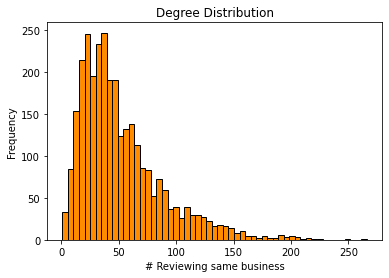

In [10]:
# print number of nodes and edges
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')
# print degree stats
degrees = [G.degree(node) for node in G.nodes()]
print(f'Average degree: {sum(degrees)/G.number_of_nodes()}')
print(f'Highest degree: {max(degrees)}')
print(f'Lowest degree: {min(degrees)}')
# plot the degree distribution in a histogram
plt.hist(degrees, bins=55, color='darkorange', edgecolor='black')
plt.xlabel('# Reviewing same business')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

The degree distribution plot reveals that most nodes have a low degree, with a few highly connected nodes. This right-skewed distribution suggests that the network is not uniformly connected but instead includes a small number of hubs—reviewers who have reviewed many businesses—while the majority have fewer connections.  
The degree distribution shows similarities to a scale-free network but with notable differences. In a true scale-free network, the degree distribution follows a power-law, where the tail remains heavy, and a few hubs dominate the connections. Here, while the distribution is right-skewed, the tail tapers off more sharply, suggesting that the network does not fully conform to the scale-free model.

Unique edge weights =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 19]


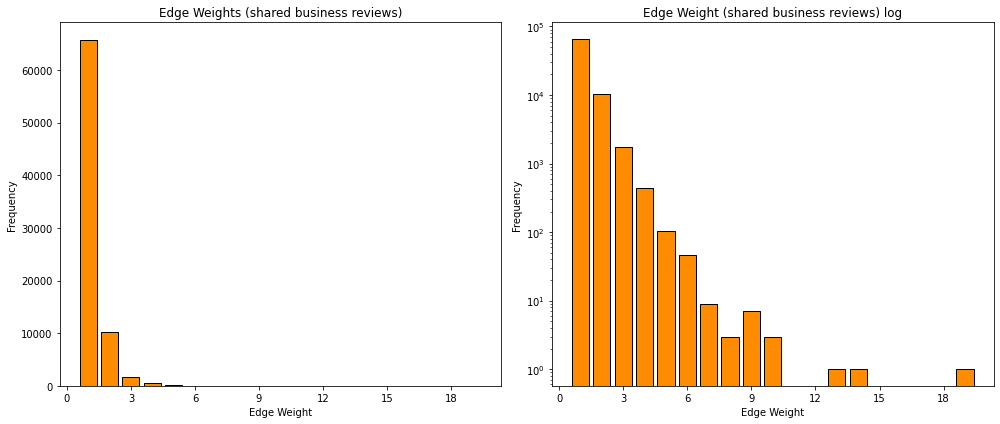

In [16]:
# Extract edge weights
edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]
unique_weights = sorted(set(edge_weights))
print("Unique edge weights = ", unique_weights)

# Calculate the frequency of each unique edge weight
weight_counts = {weight: edge_weights.count(weight) for weight in unique_weights}

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the edge weight distribution as a bar plot (linear scale)
ax1.bar(weight_counts.keys(), weight_counts.values(), color='darkorange', edgecolor='black')
ax1.set_xlabel('Edge Weight')
ax1.set_ylabel('Frequency')
ax1.set_title('Edge Weights (shared business reviews)')
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot the edge weight distribution as a bar plot (log scale)
ax2.bar(weight_counts.keys(), weight_counts.values(), color='darkorange', edgecolor='black')
ax2.set_xlabel('Edge Weight')
ax2.set_ylabel('Frequency')
ax2.set_title('Edge Weight (shared business reviews) log')
ax2.set_yscale('log')  # Use logarithmic scale for y-axis
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Adjust layout
plt.tight_layout()
plt.show()

By far the most reviewers only share a single reviewed business. Very reviewers have more than 10 businesses in common 

## Community structure

In [7]:
# Using the Python Louvain-algorithm implementation to find communities each network
partition = community_louvain.best_partition(G)
print(f'{len(set(partition.values()))} communities were found')

11 communities were found


To further analyze the relationships of reviewers and businesses, partitioning is used to explore the structure of the graph. 

The Louvain algorithm is particularly well-suited for this project due to its effectiveness in detecting communities within large networks. By optimizing modularity, it identifies groups of nodes that are densely connected internally while sparsely connected to other groups. This makes it well-aligned with the structure of the reviewer network, where natural clusters of users with overlapping business reviews are expected to emerge.

Compared to other partitioning methods, the Louvain algorithm offers a balance between computational efficiency and accuracy. Its hierarchical, iterative approach enables it to scale effectively to large graphs while providing meaningful community structures. Unlike spectral clustering, which can be computationally expensive for large networks, or simpler methods like edge-betweenness clustering, which often struggle with high complexity, Louvain is computationally efficient and can handle networks of significant size. Louvain offers flexibility in producing both coarse-grained and fine-grained partitions allowing for deeper exploration of the network's community dynamics.

In [8]:
# Calculating the modularity of the partition
modularity = community_louvain.modularity(partition, G)
print(f"Modularity of the partition: {modularity}")

Modularity of the partition: 0.6509075187617123


The modularity score for the Louvain algorithm is notably high, indicating strong community structures within the graph. This suggests that the network is well-partitioned, with dense connections within communities and sparse connections between them. Such a result aligns with the dataset's nature, where reviewers sharing similar business preferences are expected to form distinct clusters.  
The high modularity supports the validity of the graph structure and provides a solid foundation for potential meaningful insights explored below.

In [9]:
community_counts = {}
for node in partition:
    community = partition[node]
    community_counts[community] = community_counts.get(community, 0) + 1

most_common_communities = sorted(community_counts, key=community_counts.get, reverse=True)

# number of users in each community
print("Number of users in each community:")
for i in most_common_communities:
    print(f'In community {i}, there were {community_counts[i]} users')

Number of users in each community:
In community 0, there were 862 users
In community 5, there were 510 users
In community 1, there were 342 users
In community 9, there were 261 users
In community 8, there were 255 users
In community 3, there were 191 users
In community 6, there were 184 users
In community 2, there were 179 users
In community 4, there were 125 users
In community 10, there were 67 users
In community 7, there were 48 users


The output highlights a clear imbalance in the size of the detected communities. Community 8 is the largest, with 867 users, while Community 7 is the smallest, with only 48 users. This might suggest that larger communities, such as Communities 8, 5, and 1, likely represent groups of users connected by widely reviewed or popular businesses, potentially reflecting general trends or more active regions. In contrast, smaller communities, like Communities 7, 0, and 4, may indicate niche reviewing behaviors or preferences for less commonly reviewed businesses. This distribution provides a solid starting point for deeper analysis into the characteristics, geographic patterns, or sentiment trends within each community.

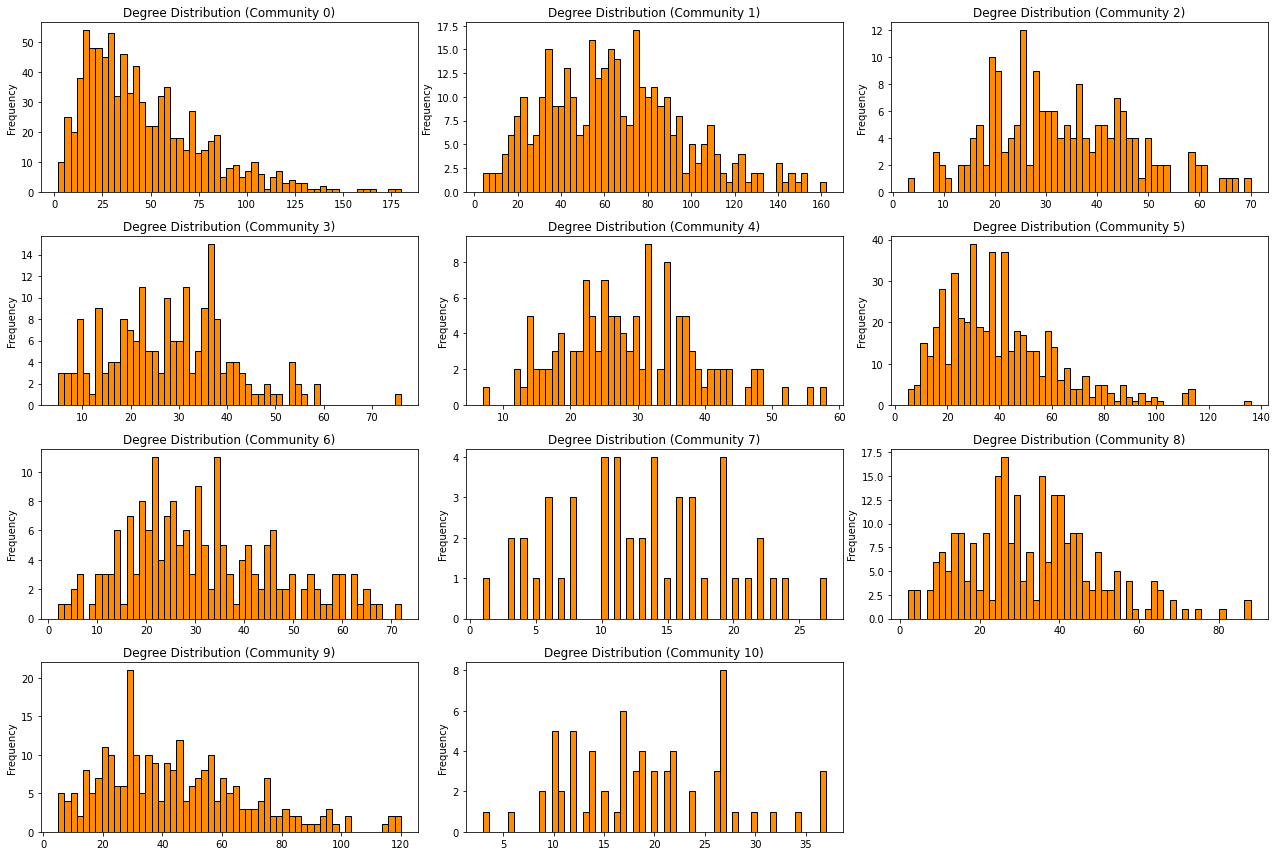

In [19]:
# community degree distributions
plot_degree_distributions(partition, G)

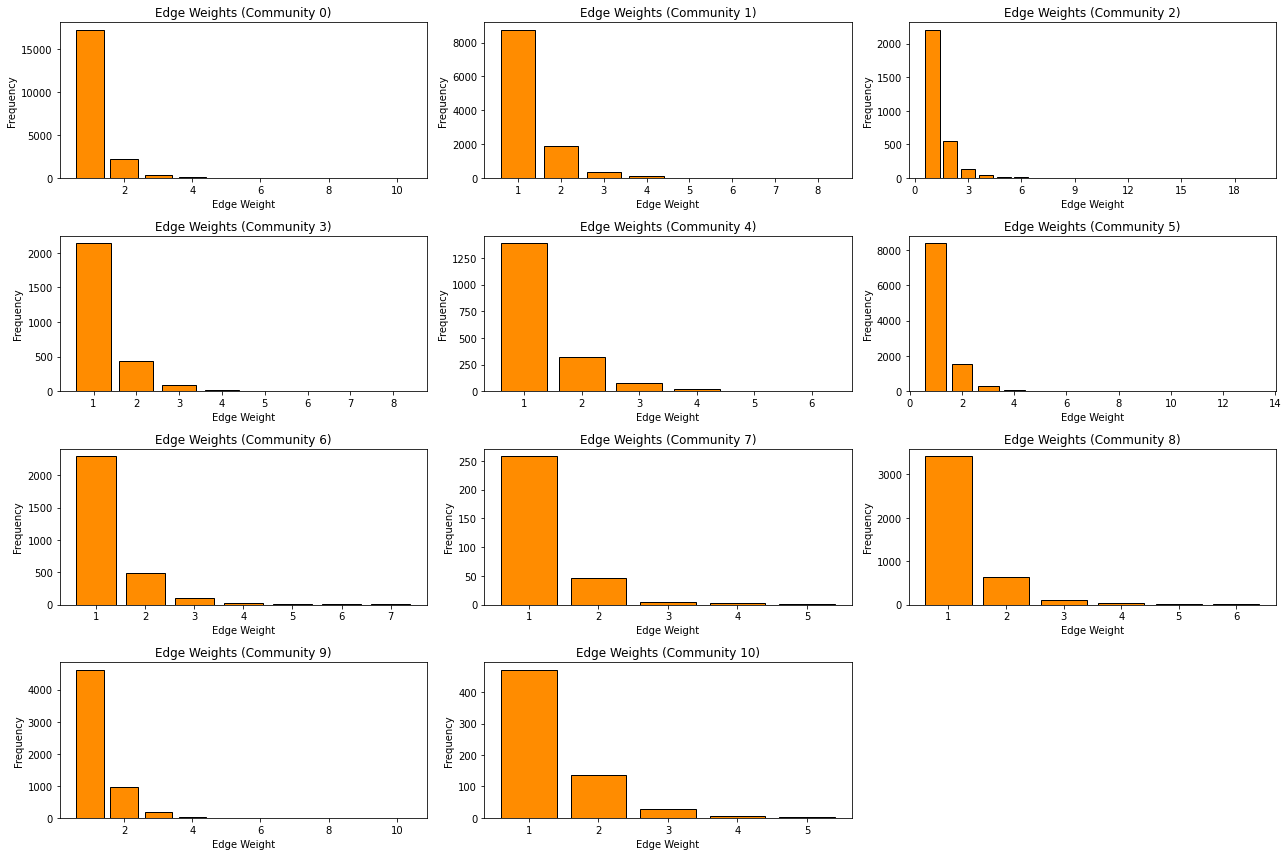

In [18]:
# Community edge weights
plot_edge_weight_distributions(partition, G)

To visualize the community structure in the full graph, network graph is created where nodes are colored according to their community, and edge thickness reflects the weights (number of shared businesses reviewed). This approach highlights the partitioning while emphasizing the strength of relationships between nodes. By adjusting the visualization to incorporate node size and edge width, we can effectively capture the dynamics of the graph in an interpretable and visually appealing way.

100%|██████████| 2000/2000 [00:02<00:00, 692.77it/s]


BarnesHut Approximation  took  1.05  seconds
Repulsion forces  took  1.40  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


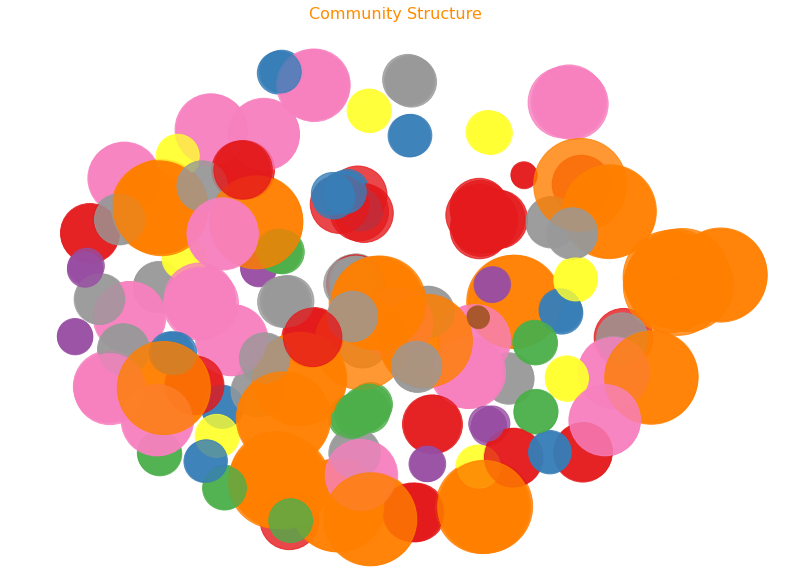

Edge thickness is proportional to the weight of the edges, representing shared businesses reviewed.
Node size is proportional to the size of the community, and node color represents the community membership.


In [18]:
# Visualize community structure

community_sizes = {comm: list(partition.values()).count(comm) for comm in set(partition.values())}
node_sizes = [community_sizes[partition[node]] * 10 for node in G.nodes]  # Adjust multiplier for visibility
threshold = 5  # Adjust threshold
filtered_edges = [(u, v) for u, v, w in G.edges(data='weight') if w >= threshold]
filtered_graph = G.edge_subgraph(filtered_edges).copy()

node_list = list(filtered_graph.nodes)
node_index = {node: idx for idx, node in enumerate(node_list)}
adj_matrix = lil_matrix((len(node_list), len(node_list)), dtype='f')

for u, v, data in filtered_graph.edges(data=True):
    adj_matrix[node_index[u], node_index[v]] = data['weight']
    adj_matrix[node_index[v], node_index[u]] = data['weight']  # Ensure symmetry for undirected graph

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,                     # Ensure it's disabled
    adjustSizes=False,                    # Ensure it's disabled
    edgeWeightInfluence=1.0,
    jitterTolerance=0.1,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    gravity=1.0,
    verbose=True
)
positions_array = forceatlas2.forceatlas2(adj_matrix, iterations=2000)
positions = {node: positions_array[idx] for node, idx in node_index.items()}
plt.figure(figsize=(14, 10))
edges, weights = zip(*nx.get_edge_attributes(filtered_graph, 'weight').items())
nx.draw_networkx_edges(
    filtered_graph, positions, edgelist=edges, alpha=0.5,
    width=[w * 0.1 for w in weights],  # Adjust multiplier for edge thickness
    edge_color=weights, edge_cmap=plt.cm.Blues  # Color edges by weight
)
nx.draw_networkx_nodes(
    filtered_graph, positions,
    node_color=[partition[node] for node in filtered_graph.nodes],
    cmap=plt.cm.Set1, node_size=[community_sizes[partition[node]] * 10 for node in filtered_graph.nodes], alpha=0.8
)
plt.title('Community Structure ', fontsize=16, color='darkorange')
plt.axis('off')
plt.show()

print("Edge thickness is proportional to the weight of the edges, representing shared businesses reviewed.")
print("Node size is proportional to the size of the community, and node color represents the community membership.")


### Community specific analysis: Aggregate metrics  
To better understand the network's structure and community dynamics, we will calculate key aggregate metrics for each community. These include the average degree, clustering coefficient, and edge density. These metrics might aid the understanding of the structural characteristics of each community and how they contribute to the overall network.

Focusing on individual communities helps us understand their internal dynamics more effectively, the following metrics are explored for each.

The average degree of a community gives insight into how well-connected the nodes within it are. It is calculated by averaging the degree (number of connections) of each node in the community. A higher average degree indicates a more interconnected and cohesive community.

The average clustering coefficient measures how likely the nodes in a community are to form tightly-knit groups, or cliques. It is calculated by averaging the clustering coefficient of each node, which assesses how many of a node’s neighbors are also connected to each other. Higher values suggest a more cohesive and tightly connected group.

Average betweenness centrality identifies nodes that act as bridges between different parts of the network. Nodes with high betweenness centrality are crucial for controlling the flow of information or resources. This metric is computed by assessing how often a node lies on the shortest path between other pairs of nodes, with higher values indicating more central nodes.

Average closeness centrality measures how efficiently a node can reach all other nodes in the network. It is calculated by averaging the shortest path lengths from each node to every other node in the community. Higher closeness centrality indicates nodes that can quickly access other nodes, making them important for spreading information or influence within the community.

These metrics help uncover the structural characteristics of communities, revealing how they interact with each other and their role within the broader network.

In [ ]:
# TAKES A LONG TIME TO RUN
# TODO: Maybe add edge weight metrics for each community
# TODO: Add something about the number of members in communities maybe

# Group nodes by their community IDs
community_dict = {}
for node, community in partition.items():
    if community not in community_dict:
        community_dict[community] = []
    community_dict[community].append(node)

# Community metrics

degree_dict = dict(G.degree())
clustering_dict = nx.clustering(G)
betweenness_dict = nx.betweenness_centrality(G)
closeness_dict = nx.closeness_centrality(G)

community_metrics = []
for community, nodes in tqdm(community_dict.items()):

    degrees = [degree_dict[node] for node in nodes]
    clusterings = [clustering_dict[node] for node in nodes]
    betweenness = [betweenness_dict[node] for node in nodes]
    closeness = [closeness_dict[node] for node in nodes]
    
    avg_degree = sum(degrees) / len(degrees)
    avg_clustering = sum(clusterings) / len(clusterings)
    avg_betweenness = sum(betweenness) / len(betweenness)
    avg_closeness = sum(closeness) / len(closeness)
    
    community_metrics.append({
        "Community": community,
        "Average Degree": avg_degree,
        "Average Clustering Coefficient": avg_clustering,
        "Average Betweenness Centrality": avg_betweenness,
        "Average Closeness Centrality": avg_closeness
    })

community_metrics_df = pd.DataFrame(community_metrics)

# If the DataFrame is empty, print a message
if community_metrics_df.empty:
    print("No community metrics were generated")

community_metrics_df.to_csv('data/community_metrics.csv', index=False)


In [27]:
community_metrics_df = pd.read_csv('data/community_metrics.csv')
# Calculate the number of nodes in each community TODO: add to the previous function before saving again to .csv
community_metrics_df['Total Reviewers'] = community_metrics_df['Community'].map(community_counts)
community_metrics_df.head()

,Community,Average Degree,Average Clustering Coefficient,Average Betweenness Centrality,Average Closeness Centrality,Total Reviewers
0,0,53.878753,0.227047,0.000568,0.368181,862
1,1,89.587719,0.287653,0.001160,0.399228,342
2,2,40.921788,0.298751,0.000577,0.342736,179
3,3,35.697917,0.269956,0.000459,0.341271,191
4,4,39.728000,0.293179,0.000380,0.354437,125


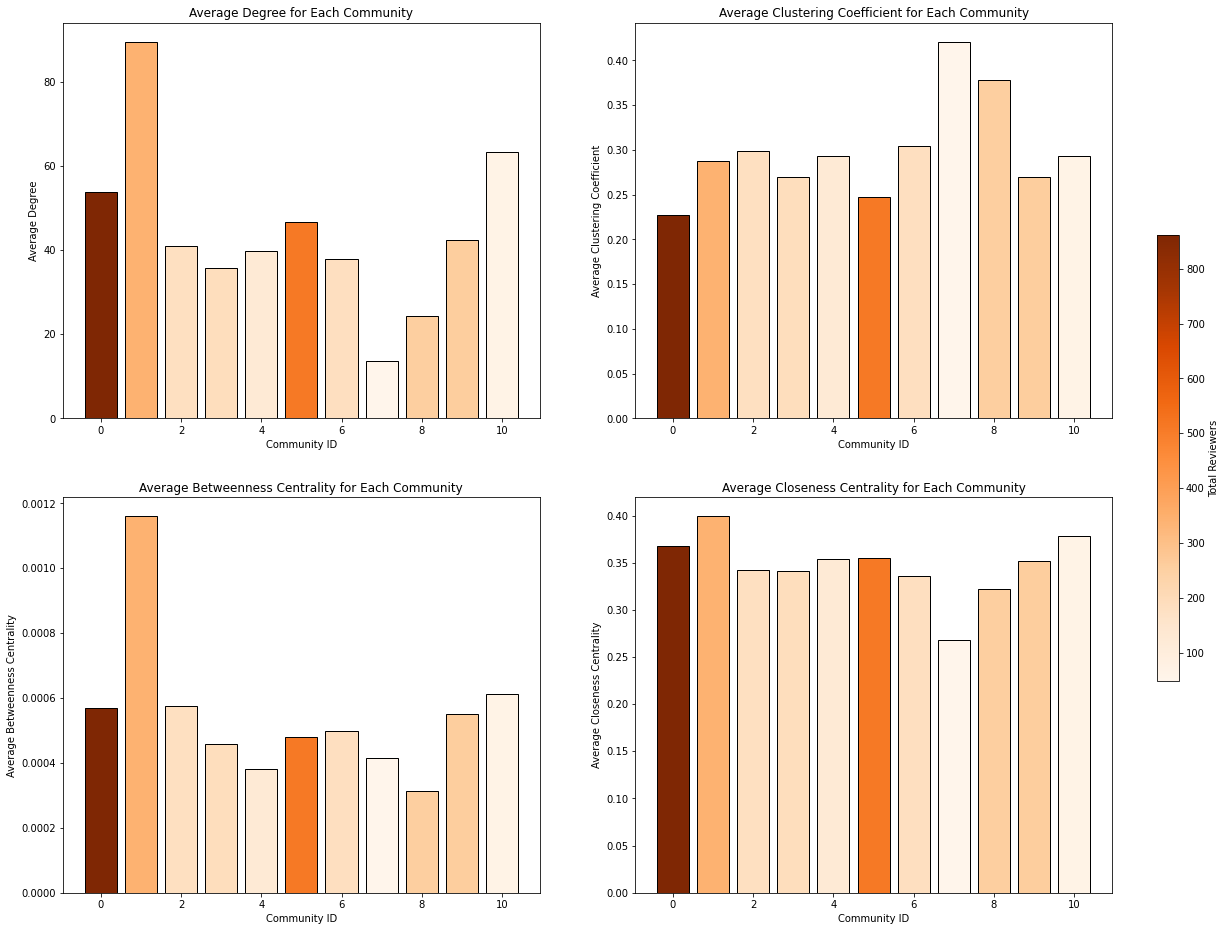

In [ ]:

metrics = community_metrics_df.columns[1:-1]
plot_community_metrics(community_metrics_df, metrics, figsize=(20, 16))

Comments for the metric plots:  

Community 7’s low average degree combined with its high clustering coefficient indicates that, while it may have relatively few connections to the rest of the network or even internally, the nodes that are connected form a highly cohesive, tightly-knit structure. This could suggest specialized or fragmented behavior, hierarchical or niche relationships, or simply an isolated yet internally connected substructure within the broader network.  It is one of the smallest networks wich might make the results more uncertain.

Community 1's high centrality measures (betweenness, closeness) and high degree position it as a critical, well-connected hub within the network. However, the relatively low clustering coefficient suggests that, while the nodes are key to maintaining network connectivity and facilitating the spread of information or influence, they are not as strongly interconnected locally. This points to a community that plays a functional or structural role in the network rather than being a group of tightly-knit, socially cohesive nodes. Community 1 may serve as a central connector across the network, rather than a collaborative or close-knit group.





### Business and community relationships

In [ ]:
# load business and review data

review_data = pd.read_json(f'data/sorted_review_data.json', lines=True)
business_data = pd.read_csv('data/businesses_reviewed.csv')

In [47]:
business_data.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
1,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ""'none'"", 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
2,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
3,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
4,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': ""u'quiet'"", 'GoodForMeal': ""{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."


In [48]:

review_data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,T5442QeVY13MWJuKbvtgnQ,6SoUQtbIltsun0IIGqWTqA,---kPU91CF4Lq2-WlRu9Lw,4,0,0,0,Excellent food and service. Portions are a lit...,2021-11-28 16:40:02
1,c0PMuZecG8uKZpzlYEs36Q,QM3cNh-u31Z5alYC3h1RnA,--FcbSxK1AoEtEAxOgBaCw,1,1,1,0,I used to come here quite frequently but never...,2018-05-13 13:12:18
2,S8-rmUixe0CANmCMblYl2A,qi6OJ4D1e_T_AUQGHtadvA,--MbOh2O1pATkXa7xbU6LA,4,1,0,0,"For what it is, they make a solid product. Li...",2013-04-14 22:31:08
3,dAoF6rmPQY72tejRqEwDKA,qgLwRvE6JkK_KnbuT5AKmA,--O3ip9NpXTKD4oBS1pY2A,4,7,2,3,There are only a few Kid Friendly places in Sa...,2017-02-11 18:55:08
4,fqWMiA-8VpG-eTuF1YzZGQ,4lng77gRdpRb24o91sSihA,--S43ruInmIsGrnnkmavRw,3,3,1,1,While I liked the layout and some of the selec...,2015-03-22 23:56:41
